# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('../amazon-fine-food-reviews/database.sqlite') 
 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

C:\Users\Dell\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'any', "hadn't", 'ourselves', 'up', 'does', 'hasn', 'yours', 'ma', 'yourselves', 'an', "shouldn't", 'do', "shan't", 'hers', 'll', 'wouldn', 'he', 'here', 'mightn', 'doing', 'they', 't', 'above', 'are', 'have', 'few', 'between', 'before', 'where', "aren't", "hasn't", 'wasn', 'been', "mustn't", 'under', 'will', 'himself', 'them', 'very', 'won', 'shan', 'with', 'or', 'm', 'how', 'whom', 'then', 'only', 'being', 'haven', 'after', 's', 'both', 'because', 'more', 'my', 'own', 'all', 'further', 'a', 're', "needn't", 've', 'be', 'same', "haven't", 'while', 'her', 'into', 'until', 'y', 'its', 'hadn', 'having', 'you', 'theirs', 'themselves', "it's", 'at', 'about', 'doesn', "couldn't", 'our', 'in', 'during', 'isn', "should've", 'can', 'these', "didn't", "isn't", 'out', 'there', 'down', 'over', 'herself', 'if', 'below', 'again', 'o', 'ain', 'his', 'now', 'it', 'no', 'as', 'other', 'to', 'couldn', 'their', 'aren', 'of', 'so', 'this', 'for', 'some', 'which', 'ours', 'just', 'than', 'she', 'didn', '

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
#conn = sqlite3.connect('final.sqlite')
#c=conn.cursor()
#conn.text_factory = str
#final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [15]:
# Getting Equal Positive and Negative Reviews
final_positive=final[final['Score']=='positive'][0:50000]
final_negative=final[final['Score']=='negative'][0:50000]

In [16]:
final_positive.shape

(50000, 11)

In [17]:
final_negative.shape

(50000, 11)

In [18]:
# Joining the Reviews
final_np=pd.concat([final_positive,final_negative])
final_np.shape

(100000, 11)

In [19]:
final_np['Score'].value_counts()

negative    50000
positive    50000
Name: Score, dtype: int64

In [20]:
# Sorting data based on time
final_np["Time"] = pd.to_datetime(final_np["Time"], unit = "s")
final_np = final_np.sort_values(by = "Time")


In [21]:
final_np.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


# Optimal alpha for MultinomialNB and BernoulliNB

In [22]:
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

def optimal_m_naive_bayes(x_train,y_train):
   
    #creating 
    alpha_param =[20,15,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001] 

    #empty list that will hold cv scores
    cv_scores = []

    #perform 10-fold cross validation
    for alpha in alpha_param:
        mnb = MultinomialNB(alpha=alpha)
        scores = cross_val_score(mnb, x_train, y_train, cv=10,scoring='f1_weighted')
        cv_scores.append(scores.mean())
        
    #changing to misclassification error
    MSE=[1-x for x in cv_scores]

    #determining best alpha
    optimal_alpha = alpha_param[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' %optimal_alpha)


    plt.figure(figsize=(10,6))
    plt.plot(alpha_param,MSE,color='blue', linestyle='-', marker='+',
             markerfacecolor='red', markersize=6)
    plt.title('Error Rate vs. alpha')
    plt.xlabel('Value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each alpha value is : ", np.round(MSE,3))
    
    return optimal_alpha

def optimal_b_naive_bayes(x_train,y_train):
   
    #creating 
    alpha_param =[20,15,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001] 

    #empty list that will hold cv scores
    cv_scores = []

    #perform 10-fold cross validation
    for alpha in alpha_param:
        mnb = BernoulliNB(alpha=alpha)
        scores = cross_val_score(mnb, x_train, y_train, cv=10,scoring='f1_weighted')
        cv_scores.append(scores.mean())
        
    #changing to misclassification error
    MSE=[1-x for x in cv_scores]

    #determining best alpha
    optimal_alpha =alpha_param[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' %optimal_alpha)


    plt.figure(figsize=(10,6))
    plt.plot(alpha_param,MSE,color='blue', linestyle='-', marker='+',
             markerfacecolor='red', markersize=6)
    plt.title('Error Rate vs. alpha')
    plt.xlabel('Value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each alpha value is : ", np.round(MSE,3))
    
    return optimal_alpha

def confusion_matrix_np(cm):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix for MultinomialNB")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()# Features from Vectorizer
    feature_n = clf.feature_log_prob_[0]# Negative feature Probability
    feature_p = clf.feature_log_prob_[1]# Positive feature Probability
    sorted_feature_n = np.argsort(feature_n)[::-1]# Sorting Negative Features
    sorted_feature_p = np.argsort(feature_n)[::-1]# Sorting Positive Features
    
    print("Top 25 Positive Features")
    for i in list(sorted_feature_p[0:n]):
        print("{}\t -->\t{}  ".format(feature_names[i],feature_p[i]))
    print("\n\n\n")
    print("Top 25 Negative Features")
    for i in list(sorted_feature_n[0:n]):
        print("{}\t -->\t{}  ".format(feature_names[i],feature_n[i]))


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# [7.2.2] Bag of Words (BoW)

In [23]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [24]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)

In [27]:
X_test=count_vect.transform(X_test)

# MultinomialNB


The optimal number of alpha is 5.


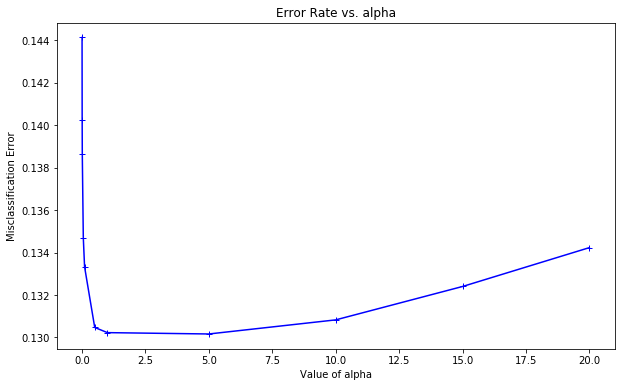

the misclassification error for each alpha value is :  [0.134 0.132 0.131 0.13  0.13  0.13  0.133 0.135 0.139 0.14  0.144]


5

In [28]:
#MultinomialNB
optimal_a_bow = optimal_m_naive_bayes(X_train, y_train)
optimal_a_bow

In [29]:
#Check for the optimal knn value
mnb_optimal= MultinomialNB(alpha=optimal_a_bow)

# Fitting the optimal model
mnb_optimal.fit(X_train, y_train)

# Predict
pred = mnb_optimal.predict(X_test)

In [30]:
# Accuracy on train data
train_acc_bow = mnb_optimal.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)

Train Accuracy 88.18142857142857


In [31]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test, pred) * 100
print("Test Accuracy ",test_acc_bow)

Test Accuracy  86.89


In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred)
cm

array([[13048,  1936],
       [ 1997, 13019]], dtype=int64)

In [33]:
# Classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.87      0.87      0.87     14984
   positive       0.87      0.87      0.87     15016

avg / total       0.87      0.87      0.87     30000



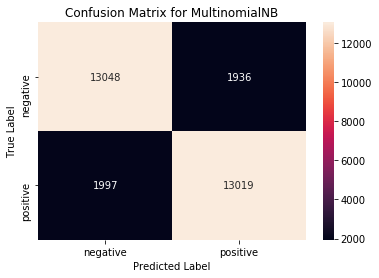

In [34]:
confusion_matrix_np(cm)

In [35]:
show_most_informative_features(count_vect,mnb_optimal)

Top 25 Positive Features
tast	 -->	-4.738560276252024  
like	 -->	-4.6586204364750206  
product	 -->	-5.001971261549205  
one	 -->	-4.933626909583232  
flavor	 -->	-4.952153105211115  
would	 -->	-5.571902120816192  
tri	 -->	-5.073900455080288  
use	 -->	-4.775986015164246  
good	 -->	-4.8247639305110965  
buy	 -->	-5.543706105905025  
coffe	 -->	-5.887170884084981  
get	 -->	-5.190680254184194  
order	 -->	-5.632334453429074  
food	 -->	-5.309746719091828  
tea	 -->	-4.703319785491926  
dont	 -->	-5.657647331407128  
even	 -->	-5.777107971443735  
box	 -->	-6.000251522757946  
amazon	 -->	-5.643743259376311  
time	 -->	-5.412156263500654  
bag	 -->	-5.754911697046678  
make	 -->	-5.103596765400649  
eat	 -->	-5.539491876665439  
much	 -->	-5.666163077492008  
realli	 -->	-5.563969863612478  




Top 25 Negative Features
tast	 -->	-4.355314963357866  
like	 -->	-4.416101856483099  
product	 -->	-4.537137012303569  
one	 -->	-4.8489811211686735  
flavor	 -->	-4.922564516905814  
would	

# BernoulliNB


The optimal number of alpha is 0.


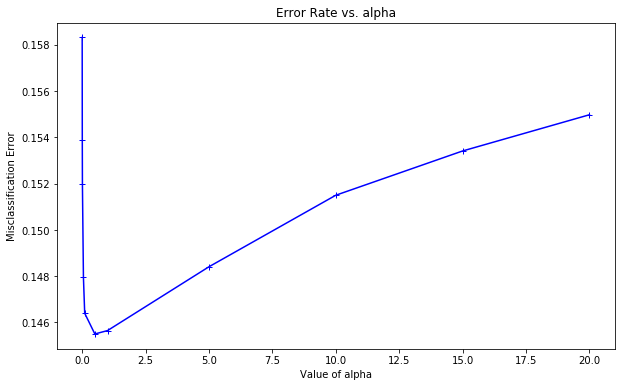

the misclassification error for each alpha value is :  [0.155 0.153 0.152 0.148 0.146 0.146 0.146 0.148 0.152 0.154 0.158]


0.5

In [36]:
#BernoulliNB
optimal_a_bow = optimal_b_naive_bayes(X_train, y_train)
optimal_a_bow

In [37]:
#Check for the optimal knn value
bnb_optimal = BernoulliNB(alpha=optimal_a_bow)

# Fitting the optimal model
bnb_optimal.fit(X_train, y_train)

# Predict
pred = bnb_optimal.predict(X_test)

In [38]:
# Accuracy on train data
train_acc_bow = bnb_optimal.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)

Train Accuracy 87.79857142857142


In [39]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test, pred) * 100
print("Test Accuracy ",test_acc_bow)

Test Accuracy  85.40666666666667


In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred)
cm

array([[12222,  2762],
       [ 1616, 13400]], dtype=int64)

In [41]:
# Classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.88      0.82      0.85     14984
   positive       0.83      0.89      0.86     15016

avg / total       0.86      0.85      0.85     30000



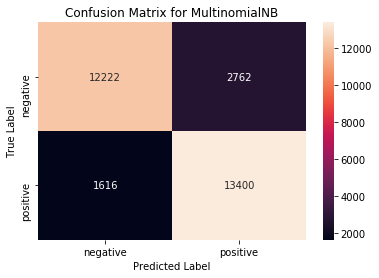

In [42]:
confusion_matrix_np(cm)

In [43]:
show_most_informative_features(count_vect,bnb_optimal)

Top 25 Positive Features
tast	 -->	-1.3189549925457094  
like	 -->	-1.2766782285933314  
product	 -->	-1.5677987586680473  
one	 -->	-1.5120770089663544  
would	 -->	-2.067084307523009  
tri	 -->	-1.603098182541892  
good	 -->	-1.3441755088693945  
flavor	 -->	-1.5710943332264566  
buy	 -->	-1.981626932400113  
get	 -->	-1.7037124703263853  
use	 -->	-1.4335564665544673  
dont	 -->	-2.108824283959933  
order	 -->	-2.1494353426848285  
even	 -->	-2.20464089128234  
make	 -->	-1.6189874375265898  
time	 -->	-1.871209241389172  
much	 -->	-2.081186667929135  
realli	 -->	-2.0320202471809985  
amazon	 -->	-2.088313134871303  
love	 -->	-1.282226663068851  
look	 -->	-2.537697947745264  
eat	 -->	-2.079584470287241  
bought	 -->	-2.586605638256553  
food	 -->	-2.1843733940461085  
disappoint	 -->	-3.945742229569155  




Top 25 Negative Features
tast	 -->	-1.0087741428440413  
like	 -->	-1.0230499590721944  
product	 -->	-1.1909782391339565  
one	 -->	-1.3646830453063856  
would	 -->	-1.425

# Observations
For MultinomialNB the alpha value is 5 and for BernoulliNB the alpha value decreased to 0.5 as well the accuracy decreased from 86 to 85 on the test dataset.

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [44]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [45]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [46]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)


shape of y: (100000,)


In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [48]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
X_train = count_vect.fit_transform(X_train)


In [49]:
X_test=count_vect.transform(X_test)

# MultinomialNB


The optimal number of alpha is 1.


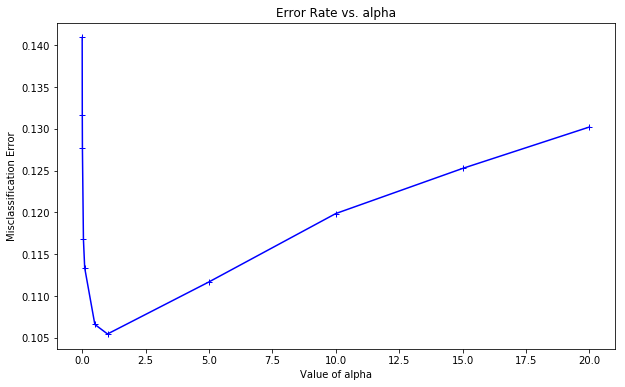

the misclassification error for each alpha value is :  [0.13  0.125 0.12  0.112 0.105 0.107 0.113 0.117 0.128 0.132 0.141]


1

In [50]:
#MultinomialNB
optimal_a_bigram = optimal_m_naive_bayes(X_train, y_train)
optimal_a_bigram

In [51]:
#Check for the optimal knn value
mnb_optimal= MultinomialNB(alpha=optimal_a_bigram)

In [52]:
# Fitting the optimal model
mnb_optimal.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [53]:
# Predict
pred = mnb_optimal.predict(X_test)

In [54]:
# Accuracy on train data
train_acc_bigram = mnb_optimal.score(X_train, y_train)
print("Train Accuracy", train_acc_bigram*100)


Train Accuracy 98.00142857142858


In [55]:
# Accuracy on test data
test_acc_bigram = accuracy_score(y_test, pred) * 100
print("Test Accuracy ",test_acc_bigram)

Test Accuracy  89.22


In [56]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred)
cm

array([[13406,  1578],
       [ 1656, 13360]], dtype=int64)

In [57]:
# Classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.89      0.89      0.89     14984
   positive       0.89      0.89      0.89     15016

avg / total       0.89      0.89      0.89     30000



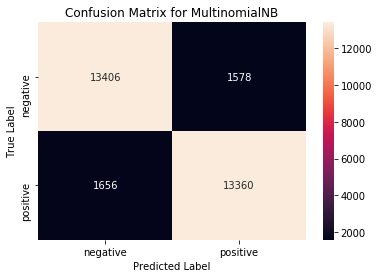

In [58]:
confusion_matrix_np(cm)

In [59]:
show_most_informative_features(count_vect,mnb_optimal)

Top 25 Positive Features
tast	 -->	-5.636754780864148  
like	 -->	-5.556790760683276  
product	 -->	-5.900260620435441  
one	 -->	-5.831889208442162  
flavor	 -->	-5.850422557450747  
would	 -->	-6.470506181462175  
tri	 -->	-5.972220364050873  
use	 -->	-5.674192522335204  
good	 -->	-5.722986770812929  
buy	 -->	-6.442290023868788  
coffe	 -->	-6.786043502894765  
get	 -->	-6.0890546917350115  
order	 -->	-6.530983648737777  
food	 -->	-6.208183716316148  
tea	 -->	-5.601503391815809  
dont	 -->	-6.556316258270309  
even	 -->	-6.6758770721726926  
box	 -->	-6.899243068154709  
amazon	 -->	-6.542401286076391  
time	 -->	-6.310653364014945  
bag	 -->	-6.653661267939992  
make	 -->	-6.001929942487452  
eat	 -->	-6.438072832589681  
much	 -->	-6.564838755598185  
realli	 -->	-6.462568200036575  




Top 25 Negative Features
tast	 -->	-5.2372510654605335  
like	 -->	-5.298050240749724  
product	 -->	-5.419112192283139  
one	 -->	-5.731042322768484  
flavor	 -->	-5.804650237806499  
would	

# BernoulliNB


The optimal number of alpha is 0.


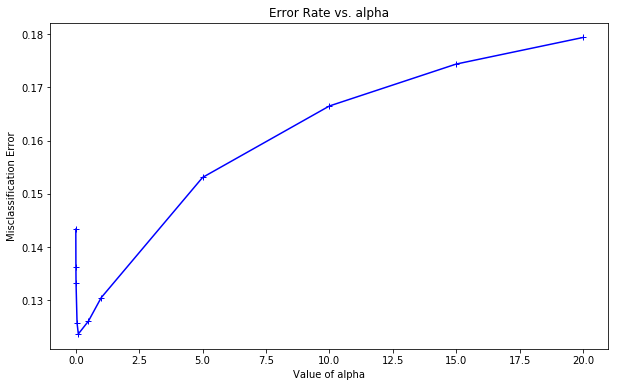

the misclassification error for each alpha value is :  [0.179 0.174 0.167 0.153 0.131 0.126 0.124 0.126 0.133 0.136 0.143]


0.1

In [60]:
#BernoulliNB
optimal_a_bigram = optimal_b_naive_bayes(X_train, y_train)
optimal_a_bigram

In [61]:
#Check for the optimal knn value
bnb_optimal = BernoulliNB(alpha=optimal_a_bigram)

In [62]:
# Fitting the optimal model
bnb_optimal.fit(X_train, y_train)

BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)

In [63]:
# Predict
pred = bnb_optimal.predict(X_test)

In [64]:
# Accuracy on train data
train_acc_bigram = bnb_optimal.score(X_train, y_train)
print("Train Accuracy", train_acc_bigram*100)

Train Accuracy 99.07285714285715


In [65]:
# Accuracy on test data
test_acc_bigram = accuracy_score(y_test, pred) * 100
print("Test Accuracy ",test_acc_bigram)

Test Accuracy  87.35666666666667


In [66]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred)
cm

array([[12428,  2556],
       [ 1237, 13779]], dtype=int64)

In [67]:
# Classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.91      0.83      0.87     14984
   positive       0.84      0.92      0.88     15016

avg / total       0.88      0.87      0.87     30000



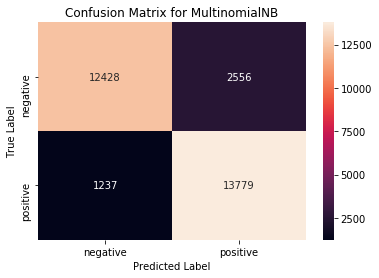

In [68]:
confusion_matrix_np(cm)

In [69]:
show_most_informative_features(count_vect,bnb_optimal)

Top 25 Positive Features
tast	 -->	-1.3189748818536398  
like	 -->	-1.2766963479350757  
product	 -->	-1.5678307288023756  
one	 -->	-1.5121060069642756  
would	 -->	-2.0671517888380553  
tri	 -->	-1.6031321230292406  
good	 -->	-1.3441964902557881  
flavor	 -->	-1.5711264843844202  
buy	 -->	-1.981687013166617  
get	 -->	-1.7037524240979014  
use	 -->	-1.4335815477575622  
dont	 -->	-2.108895616411745  
order	 -->	-2.1495105796180205  
even	 -->	-2.2047216966799272  
make	 -->	-1.619022287881302  
time	 -->	-1.8712606504553655  
much	 -->	-2.081255432456839  
realli	 -->	-2.0320846152720247  
amazon	 -->	-2.0883825547721226  
love	 -->	-1.2822450104585155  
look	 -->	-2.5378197303078407  
eat	 -->	-2.0796530881136377  
bought	 -->	-2.5867346717093866  
disappoint	 -->	-3.9463108158789364  
food	 -->	-2.1844521193036073  




Top 25 Negative Features
tast	 -->	-1.0087826216682334  
like	 -->	-1.023058888302618  
product	 -->	-1.19099297868698  
one	 -->	-1.364704915218903  
would	 -->	

# Observations
For MultinomialNB the alpha value is 1 and for BernoulliNB the alpha value decreased to 0.1 but the accuracy increased on train set i.e from 98 to 99 whereas the accuracy on test set decreased from 87 to 85.

# [7.2.5] TF-IDF

In [70]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)


shape of X: (100000,)


In [71]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [73]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<70000x32804 sparse matrix of type '<class 'numpy.float64'>'
	with 2216810 stored elements in Compressed Sparse Row format>

In [74]:
X_test = tf_idf_vect.transform(X_test)
X_test

<30000x32804 sparse matrix of type '<class 'numpy.float64'>'
	with 950862 stored elements in Compressed Sparse Row format>

# MultinomialNB


The optimal number of alpha is 5.


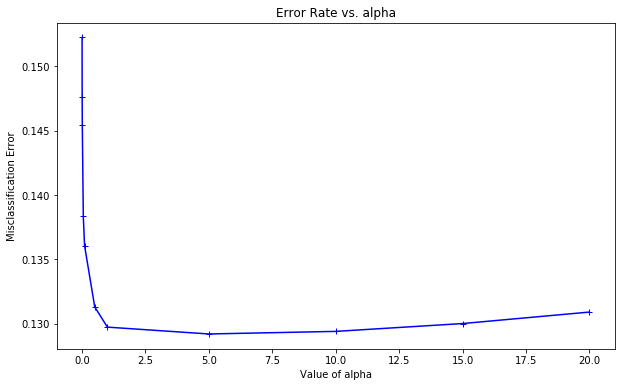

the misclassification error for each alpha value is :  [0.131 0.13  0.129 0.129 0.13  0.131 0.136 0.138 0.145 0.148 0.152]


5

In [75]:
#MultinomialNB
optimal_a_tfidf = optimal_m_naive_bayes(X_train, y_train)
optimal_a_tfidf

In [76]:
#Check for the optimal alpha value
mnb_optimal= MultinomialNB(alpha=optimal_a_tfidf)

In [77]:
# Fitting the optimal model
mnb_optimal.fit(X_train, y_train)

MultinomialNB(alpha=5, class_prior=None, fit_prior=True)

In [78]:
# Predict
pred = mnb_optimal.predict(X_test)

In [79]:
# Accuracy on train data
train_acc_tfidf = mnb_optimal.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidf*100)

Train Accuracy 88.27000000000001


In [80]:
# Accuracy on test data
test_acc_tfidf = accuracy_score(y_test, pred) * 100
print("Test Accuracy ",test_acc_tfidf)

Test Accuracy  87.03


In [81]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred)
cm

array([[13159,  1825],
       [ 2066, 12950]], dtype=int64)

In [82]:
# Classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.86      0.88      0.87     14984
   positive       0.88      0.86      0.87     15016

avg / total       0.87      0.87      0.87     30000



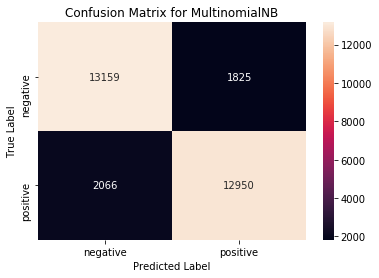

In [83]:
confusion_matrix_np(cm)

In [84]:
show_most_informative_features(tf_idf_vect,mnb_optimal)

Top 25 Positive Features
tast	 -->	-5.95163608430605  
like	 -->	-5.968511841571702  
product	 -->	-6.042725718984907  
flavor	 -->	-6.032940120083073  
coffe	 -->	-6.620606426550865  
would	 -->	-6.682019937643783  
one	 -->	-6.160422223417808  
tri	 -->	-6.221271917646872  
buy	 -->	-6.440597573376524  
order	 -->	-6.447197426959379  
good	 -->	-5.838098989106352  
tea	 -->	-5.589513619335299  
box	 -->	-6.94356579191625  
dont	 -->	-6.736881074080613  
get	 -->	-6.29165044772102  
use	 -->	-5.941715266781483  
food	 -->	-6.3823657996898735  
bag	 -->	-6.674635105674765  
disappoint	 -->	-8.304903335426602  
even	 -->	-6.833784042627605  
amazon	 -->	-6.487556595960102  
eat	 -->	-6.461548100315457  
purchas	 -->	-6.974339938223491  
packag	 -->	-7.081673107086324  
dog	 -->	-6.2748206596217715  




Top 25 Negative Features
tast	 -->	-5.530731624470017  
like	 -->	-5.671362286460646  
product	 -->	-5.7146791424041785  
flavor	 -->	-5.987923868016145  
coffe	 -->	-5.994328679811792  

# BernoulliNB


The optimal number of alpha is 0.


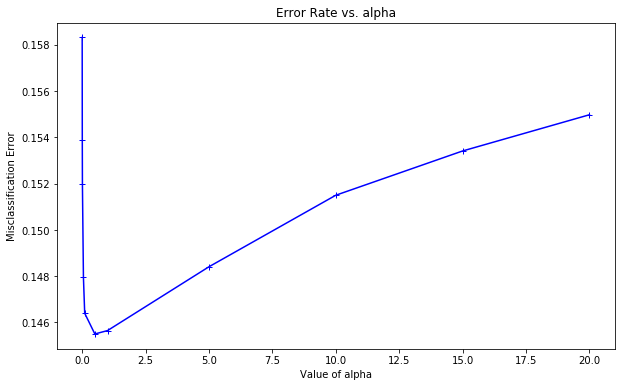

the misclassification error for each alpha value is :  [0.155 0.153 0.152 0.148 0.146 0.146 0.146 0.148 0.152 0.154 0.158]


0.5

In [85]:
#BernoulliNB
optimal_a_tfidf = optimal_b_naive_bayes(X_train, y_train)
optimal_a_tfidf

In [86]:
#Check for the optimal knn value
bnb_optimal = BernoulliNB(alpha=optimal_a_tfidf)

In [87]:
# Fitting the optimal model
bnb_optimal.fit(X_train, y_train)

BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior=True)

In [88]:
# Predict
pred = bnb_optimal.predict(X_test)

In [89]:
# Accuracy on train data
train_acc_tfidf = bnb_optimal.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidf*100)

Train Accuracy 87.79857142857142


In [90]:
# Accuracy on test data
test_acc_tfidf = accuracy_score(y_test, pred) * 100
print("Test Accuracy ",test_acc_tfidf)

Test Accuracy  85.40666666666667


In [91]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred)
cm

array([[12222,  2762],
       [ 1616, 13400]], dtype=int64)

In [92]:
# Classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.88      0.82      0.85     14984
   positive       0.83      0.89      0.86     15016

avg / total       0.86      0.85      0.85     30000



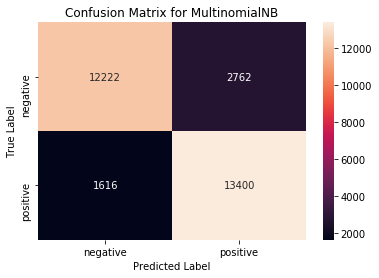

In [93]:
confusion_matrix_np(cm)

In [94]:
show_most_informative_features(tf_idf_vect,bnb_optimal)

Top 25 Positive Features
tast	 -->	-1.3189549925457094  
like	 -->	-1.2766782285933314  
product	 -->	-1.5677987586680473  
one	 -->	-1.5120770089663544  
would	 -->	-2.067084307523009  
tri	 -->	-1.603098182541892  
good	 -->	-1.3441755088693945  
flavor	 -->	-1.5710943332264566  
buy	 -->	-1.981626932400113  
get	 -->	-1.7037124703263853  
use	 -->	-1.4335564665544673  
dont	 -->	-2.108824283959933  
order	 -->	-2.1494353426848285  
even	 -->	-2.20464089128234  
make	 -->	-1.6189874375265898  
time	 -->	-1.871209241389172  
much	 -->	-2.081186667929135  
realli	 -->	-2.0320202471809985  
amazon	 -->	-2.088313134871303  
love	 -->	-1.282226663068851  
look	 -->	-2.537697947745264  
eat	 -->	-2.079584470287241  
bought	 -->	-2.586605638256553  
food	 -->	-2.1843733940461085  
disappoint	 -->	-3.945742229569155  




Top 25 Negative Features
tast	 -->	-1.0087741428440413  
like	 -->	-1.0230499590721944  
product	 -->	-1.1909782391339565  
one	 -->	-1.3646830453063856  
would	 -->	-1.425

# Observations
The optimal alpha value for MultinomialNB from 5 decresed to 0.5 for BernoulliNB.The accuracy score for MultinomialNB performs better than BernoulliNB in this case. 

In [95]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer","Algorithm","alpha","Train Accuracy","Test Accuracy","F-1 Score"]

x.add_row(["Unigram BOW", "MultinomialNB",5,88.18,86.89,0.87])
x.add_row(["Unigram BOW", "BernoulliNB",0.5,87.79,85.40,0.85])
x.add_row(["Bigram BOW", "MultinomialNB",1,98.00,89.22,0.89])
x.add_row(["Bigram BOW", "BernoulliNB",0.1,99.07,87.35,0.87])
x.add_row(["TF-IDF", "MultinomialNB",5,88.27,87.03,0.87])
x.add_row(["TF-IDF", "BernoulliNB",0.5,87.79,85.4,0.85])
print("Performance Table")
print(x)

Performance Table
+-------------+---------------+-------+----------------+---------------+-----------+
|  Vectorizer |   Algorithm   | alpha | Train Accuracy | Test Accuracy | F-1 Score |
+-------------+---------------+-------+----------------+---------------+-----------+
| Unigram BOW | MultinomialNB |   5   |     88.18      |     86.89     |    0.87   |
| Unigram BOW |  BernoulliNB  |  0.5  |     87.79      |      85.4     |    0.85   |
|  Bigram BOW | MultinomialNB |   1   |      98.0      |     89.22     |    0.89   |
|  Bigram BOW |  BernoulliNB  |  0.1  |     99.07      |     87.35     |    0.87   |
|    TF-IDF   | MultinomialNB |   5   |     88.27      |     87.03     |    0.87   |
|    TF-IDF   |  BernoulliNB  |  0.5  |     87.79      |      85.4     |    0.85   |
+-------------+---------------+-------+----------------+---------------+-----------+


# Conclusion
* Bigram BOW performs the best with accuracy equal to 89.22 and f1-score 0.89
* Accuracy for Avg-W2V and TF-IDF-W2V falls comparatively so we skip it.